## Analysis and Modelling of King County, WA Home Sale Prices


Authors: Erin Vu and Brian Matsiko

### Overview

This project analyzes the factors that determine housing prices in King County, WA, Seattle. The analysis then forms the basis of the model and is directed towards assisting the Seattle real estate and housing company with the understanding and structuring their business model with the goal of maximising home sales to inorder to meet the respective community needs while being profitable.

## Business Problems

Seattle Rental Group seeks to it's increase porfolio in King County Seattle and wants to accurately predict the sales price of a property. Having an accurate sales prediction will aid in strategizing the investment options to maximize their profit. A multiple linaer regression model will be built base on provided property data for this task.

## Aims:

This project aims to:

- Highlight feature that has the greatest correlation with the property sales prices within King County Seattle
- Identify what aspects of the real estate features bring value 
- Understand whether recently revonated and built houses more valueable.
           

## Definitions:

- Model:
    - The term model referred to through this project is in reference to the linear regression model which we build to explain the variance in home sale prices
- Features:
    - Features refer to the independent variables we choose for our model to help predict sale prices
- Target:
    - Sale Price is our target variable which our model aims to predict
- Age:
    - Recent: Refers to properties constructed after 2010.
    - Old: Refers to properties constructed after 1999 but before 2010.
    - Vintage: Refers to properties constructed before 1999.
- Renovated:
    - Not recent / never: Refers to properties that have either never been renovated or were renovated before 1999.
    - Renovated_15yrs: Refers to properties that had a renovation before 2000 but after 1999.
    - Renovated_5yrs: Refers to properties that had a renovation before 2010 but after 2000.

## Data:

The data used in this project is from the King County Department of Assessments website and can be found here. From this link, you can find the files/tables that were used in this project:

Our analysis was only looking at data from years 2014 and 2015. 

## Table of contents:

- Data Extraction
- Data Cleaning and Exploratory Data Analysis (EDA)
- Investigate Target Variable: Sales Price
- First Simple Linear Regression Model
- Model Iterations 1 - 6
- Model interpretation
- Claim Validation
- Conclusion

## Analysis Takeaways, Future Investigations and Recommendations:


- The model highlighted zipcode areas with greatest potential for property value from real estate investments. The top five neigborhoods within these zipcodes performed significantly higher when compared against the average sales price for whole county.
- The visibility of a property was also highlighted by the model as a feature that positively correlated with it's respective value.
- The model also highlighted that the interior square footage of both the properties and the nearest 15 neighboring properties significantly impacted their individual property values.
- Other features like having a waterfornt or whether the property had undergone a renovation within the last 5 or 15 yrs, also showed positive correlation to the respective property value.

## Libraries 

In [5]:
from sklearn.preprocessing import PowerTransformer
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn import metrics
import pickle
import statsmodels
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Data Extraction

In [2]:
kc = pd.read_csv("data/kc_house_data.csv")
kc.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/kc_house_data.csv'

In [ ]:
kc_r= kc.copy()

## Exploratory Data Analysis

This section will seek to answer the questions listed in business problems. The data will be visualized for easy understanding and followed with appropriate statistical analysis for empirical findings within data. 

## Data Structure

The data set contains mix of continuous and categorical values. They are separated by columns and below is a brief summary of each columns. Further details can be found in King County website.

### Column Description

- id - unique ID for a house
- date - Date day house was sold
- price - Price is prediction target
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms
- sqft_living - square footage of the home
- sqft_lot - square footage of the lot
- floors - Total floors (levels) in house
- waterfront - Whether house has a view to a waterfront
- view - Number of times house has been viewed
- condition - How good the condition is (overall)
- grade - overall grade given to the housing unit, based on King County grading system
- sqft_above - square footage of house (apart from basement)
- sqft_basement - square footage of the basement
- yr_built - Year when house was built
- yr_renovated - Year when house was renovated
- zipcode - zip code in which house is located
- lat - Latitude coordinate
- long - Longitude coordinate
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

### Data Integrity and Description

In [ ]:
kc.isna().sum()

For waterfront, view, and yr_renovated, we see that up to 75% of the distribution still remains at a value of 0. As a result, we have decided to fill the NA values in these columns with 0.

In [ ]:
#Replace null values and "nan" with 0

kc = kc.replace("nan","0")

col = ['waterfront', 'view', 'yr_renovated']

for val in col:
    kc[val] = kc[val].fillna(value=0)

In [ ]:
total_null = 0 
for null_count in kc.isna().sum():
    total_null += null_count
print(f"There are total {total_null} null values in the data")

Checking for duplicate datase

In [ ]:
#Check for duplicates
kc_duplicates = kc[kc.duplicated()]
print(len(kc_duplicates))
display(kc_duplicates)

In [ ]:
#Check for duplicated IDs 
duplicated_ids = kc.duplicated(subset=['id'], keep=False)
duplicated_ids.value_counts()

In [ ]:
#Explore duplicated IDs
kc_duplicated_ids = kc[duplicated_ids]
kc_duplicated_ids.head()

A home's latitude and longitude will not be particularly relevant for prospective homebuyers. Neither will its id,as other data, such as yr_built, will be of much more interest. As a result, we will drop these variables, as they do not make much sense in the context of our business problem.

In [ ]:
#Remove features/columns that are of no interest for this analysis 
kc.drop(['id','lat','long'], axis=1, inplace=True)

In [ ]:
kc.info()

In [ ]:
#Replacing the question mark values with 0 because majority of the values are 0's and also convert it to integers.
kc['sqft_basement'] = kc['sqft_basement'].replace(to_replace = '?', value = 0.0)
kc['sqft_basement'] = kc['sqft_basement'].astype(str).astype(float)

## Preview Distribution of Each Column

Before we conduct any transformations, we need to check the distributions in order to identify categorical variables and see if/which features are normally distributed.

In [ ]:
#First, let's plot a histogram for each column
kc.hist(figsize=(18,15), bins='auto');

Bathrooms, bedrooms, condition, floors, grade, view, waterfront, and yr_renovated are categorical. The remaining variables seem to be continuous. Let's explore this further by creating some scatter plots.

In [ ]:
#Next, let's plot scatter plots that will further help us identify outliers and categorical variables 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,15), sharey=True)

for ax, column in zip(axes.flatten(), kc.columns):
    ax.scatter(kc[column], kc['price'] / 100_000, label=column, alpha=.1)
    ax.set_title(f'Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Price in $100,000')

fig.tight_layout()

These scatter plots helped confirm which variables are categorical and which are continuous. We have identified our continuous variables, sqft_living, sqft_lot, sqft_above, sqft_basement, yr_built, sqft_living15 and sqft_lot15, and later we will look to transform some of these variables, since many of them currently do not appear to follow a normal distribution.

### Data Cleaning & Engineering.

In [ ]:
# Dropping the outlier hose with 33 bedrooms and 1.75 bathrooms showing that it must have been a data entry error.
kc.drop(kc[kc['bedrooms'] == 33].index, inplace=True)
plt.scatter(kc['bedrooms'], kc['price'])
plt.show()

In [ ]:
# Creating another copy of the semi-cleaned data
kc1 = kc.copy()

In [ ]:
# Creating ['basement'] to replace 'sqft_basement'
kc1['basement'] = kc['sqft_basement'].apply(lambda x: 0 if x == 0  else 1)
kc1['basement'].value_counts()

In [ ]:
# Creating 'Age' to replace 'yr_built' 
kc1['Age'] = kc['yr_built'].apply(lambda x: "vintage" if x <= 1999 else "recent" if x >= 2000 and x < 2010 else "new")
kc1['Age'].value_counts()

In [ ]:
# Creating 'renovated' so sa to replace the 'yr_renovated'
kc1['renovated'] = kc['yr_renovated'].apply(lambda x: "not_recent/never" if x <= 1999 else "within_15yrs" if x >= 2000 and x < 2010 else 'within_5yrs')
kc1['renovated'].value_counts()

In [ ]:
# To reduce the number of classes of bedrooms and increase variability 
kc1['bedrooms'] = kc['bedrooms'].apply(lambda x: x if x <= 6 else 6)
kc1['bedrooms'].value_counts()

In [ ]:
# Creating function for helping to create a 'seasons' dataset from the 'date' feature.
def getSeason(date):
    month = int(date.split("/")[0])
    if (month > 11 or month <= 3):
       return "Winter"
    elif (month == 4 or month == 5):
       return "Spring"
    elif (month >=6 and month <= 9):
       return "Summer"
    else:
       return "Fall"

In [ ]:
#Creating and mapping a season column.
kc1['season'] = kc1.date.map(getSeason)
kc1['season'].value_counts()

In [ ]:
# Log transforming skewed information from the bathrooms, sqft_lot, sqft_living15, sqft_above, sqft_living, price and qft_lot15 features 
kc1['bathrooms_lg'] =np.log(kc1['bathrooms'])
kc1['sqftlot_lg'] =np.log(kc1['sqft_lot'])
kc1['sqft15_lg'] =np.log(kc1['sqft_living15'])
kc1['sqftabv_lg'] =np.log(kc1['sqft_above'])
kc1['sqftlv_lg'] =np.log(kc1['sqft_living'])
kc1['price_lg'] =np.log(kc1['price'])
kc1['sqftlot_lg'] =np.log(kc1['sqft_lot15'])

In [3]:
#Remove features/columns that are of no interest for this analysis 
kc1.drop(['price','sqft_above','sqft_lot15','sqft_lot','bathrooms',
          'sqft_basement','yr_renovated', 'date','yr_built'], axis=1, inplace=True)

NameError: name 'kc1' is not defined

In [4]:
#First, let's plot a histogram for each column
kc1.hist(figsize=(18,15), bins='auto');

NameError: name 'kc1' is not defined

## Correlation Review

Our next logical step would be to investigate correlation amongst variables. First we will look at this more generally, then we will narrow our results to variables that are more highly correlated with our y-variable, price.

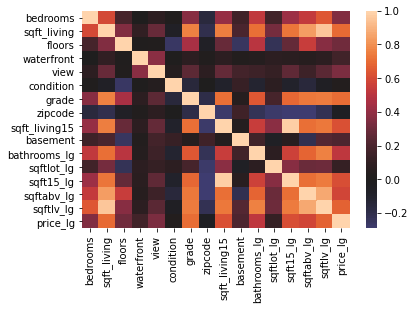

In [70]:
sns.heatmap(kc1.corr(), center=0);

In [71]:
#Look at which features are highly correlated with our y-variable, price.
kc_r.corr()[abs(kc_r.corr()['price']) > 0.3]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
grade,0.008188,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.087383,0.249727,-0.146896,1.000000,0.756073,0.447865,0.016669,-0.185771,0.113575,0.200341,0.713867,0.120981
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,0.075463,0.166299,-0.158904,0.756073,1.000000,0.424037,0.022137,-0.261570,-0.001199,0.344842,0.731767,0.195077
lat,-0.001798,0.306692,-0.009951,0.024280,0.052155,-0.085514,0.049239,-0.012772,0.006141,-0.015102,0.113575,-0.001199,-0.148370,0.032145,0.266742,1.000000,-0.135371,0.048679,-0.086139
sqft_living15,-0.002701,0.585241,0.393406,0.569884,0.756402,0.144763,0.280102,0.088860,0.279561,-0.093072,0.713867,0.731767,0.326377,-0.000247,-0.279299,0.048679,0.335626,1.000000,0.183515


We should also look at variables to see if they are correlated with each other, in order to investigate potential multicollinearity.

## First Simple Model

Since sqft_living has the highest correlation with price, then the first simple model will be to show the realtionship between this

In [72]:
formula = 'price_lg ~ sqft_living'
fsm = ols(formula, kc1).fit()
fsm_summary = fsm.summary()
print(fsm_summary)

                            OLS Regression Results                            
Dep. Variable:               price_lg   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 2.020e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        07:56:53   Log-Likelihood:                -9661.4
No. Observations:               21596   AIC:                         1.933e+04
Df Residuals:                   21594   BIC:                         1.934e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.2187      0.006   1915.377      

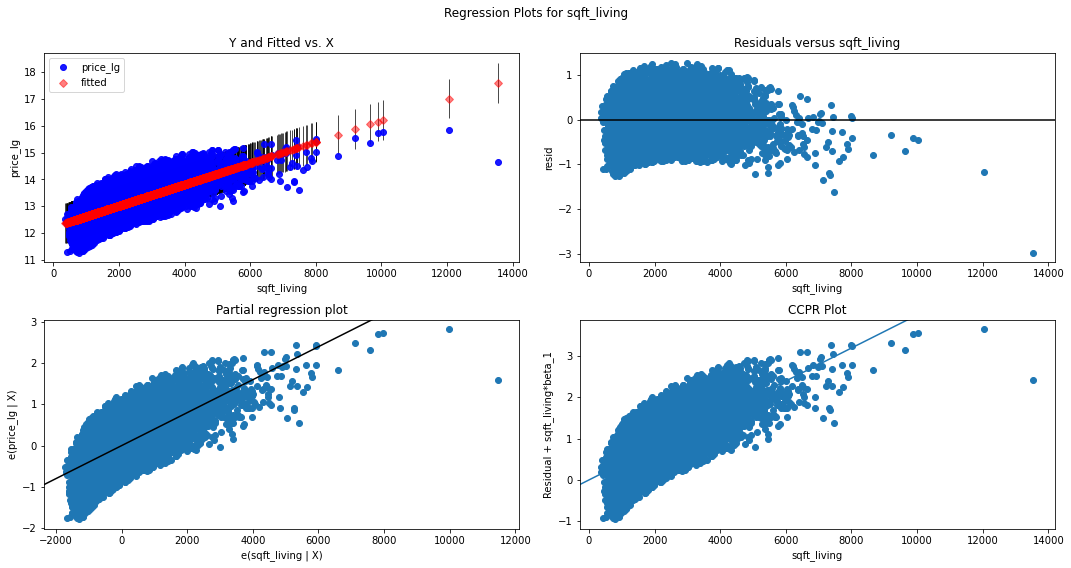

<ipython-input-73-32b758d0145e>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


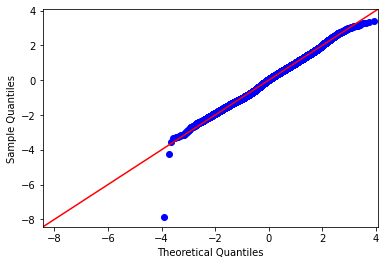

In [73]:
# Regression plots for the FSM
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(fsm, "sqft_living", fig=fig)
plt.show()

#--------------------------Residual Plots--------------------------------------#
residuals = fsm.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

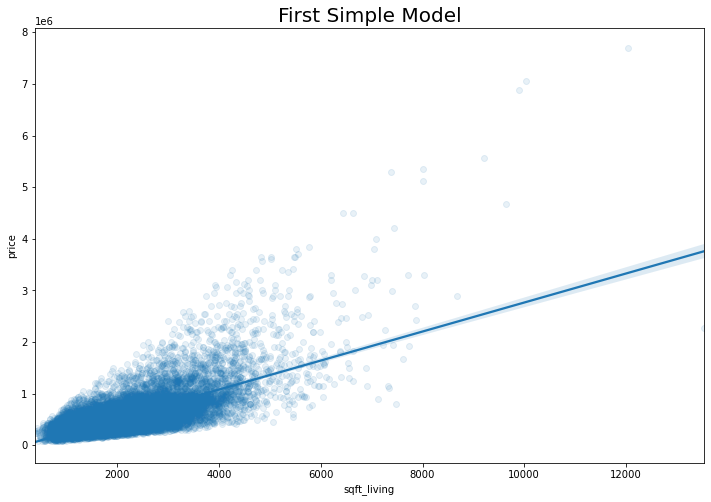

In [96]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(x="sqft_living", y="price", data=kc, scatter_kws={'alpha':0.1})
ax.set_title('First Simple Model', fontsize=20)
plt.savefig('./images/fsm',bbox_inches='tight');

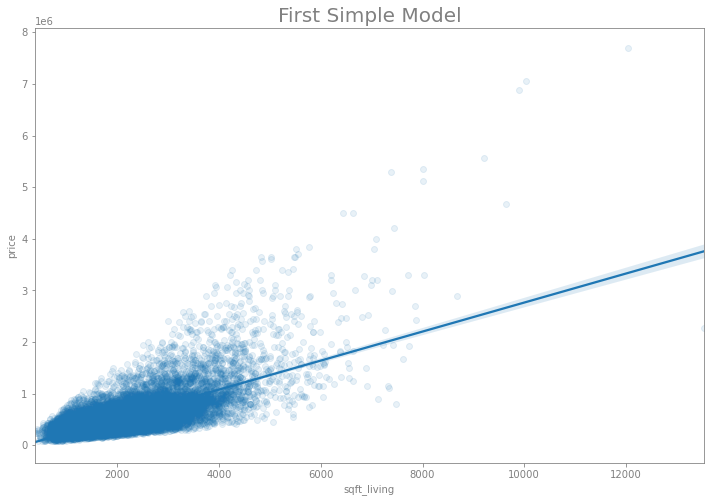

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use=('dark_background')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.yaxis.label.set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.yaxis.label.set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.xaxis.label.set_color('gray')
sns.regplot(x="sqft_living", y="price", data=kc, scatter_kws={'alpha':0.1})
ax.set_title('First Simple Model', fontsize=20, color='gray')
plt.savefig('./images/fsm_dark',bbox_inches='tight', transparent=True);

The First Simple Model betweent the highly correlating sqft_living feature with price has a low r-squared and a very high condition number indicating that there are possible numerical data issues. 

## Second Model with fixed possible numeric data issues

In [75]:
X = kc1[['sqftlv_lg']]
y = kc1['price_lg']

In [76]:
predictors_int = sm.add_constant(X)
model = sm.OLS(y, predictors_int).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               price_lg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.806e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        07:57:01   Log-Likelihood:                -10230.
No. Observations:               21596   AIC:                         2.046e+04
Df Residuals:                   21594   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7232      0.047    142.609      0.0

## Square Footage of the home Statistical Analysis

The numerical issues were eliminated by log transforming the price and sqftlv values but the model then showed that still low r squared value indicating that the square footage alone does not explain the property value of a home.

## Adding more significantly correlarated features to the model 

The square footage of interior housing living space for the nearest 15 neighbors (sqft_living15),  square footage of house (sqftabv) and the overall grade given to the housing unit, based on King County grading system (grade) seemed to have equally significant correlation with the sales price and will added to the model to evaluate its performance

In [77]:
# Setting up model variables
cat = ['grade']
catkc1 = kc[cat].astype('category')
dummies = pd.get_dummies(catkc1, prefix=cat, drop_first=True)
kc_p = kc1.drop(cat, axis=1)
kc_p = pd.concat([kc_p, dummies], axis=1)
X_1 = kc_p[['sqftlv_lg', 'sqft15_lg','sqftabv_lg','grade_4','grade_5','grade_6','grade_7','grade_8','grade_9'
            ,'grade_10','grade_11','grade_12','grade_13']]
y = kc1['price_lg']

#--------------------------Model--------------------------------------#
#Running Model
predictors_int = sm.add_constant(X_1)
model_1 = sm.OLS(y, predictors_int).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:               price_lg   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     2156.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        07:57:02   Log-Likelihood:                -7803.8
No. Observations:               21596   AIC:                         1.564e+04
Df Residuals:                   21582   BIC:                         1.575e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3863      0.356     26.385      0.0

## Statistical Analysis of the model with more significantly correlated features

Adding the three more features that were also significantly correlated to the sales price increased the r squared value of the model. However the following conclusions are made form this model:
- The overall grade given to a housing unit is not significantly correlated to the sales price of a house and thus this feature will be dropped from future versions of our model.
- The model R-squared value is still low. More features will be added to this model to see if this makes it perform better.
- Both the square footage of interior housing living space for the nearest 15 neighbors and square footage of house are significantly affect the property value.

## Adding other features to the model 

The next version of this model drops the grade and adds all the other features to further evaluate its perfomance.

In [78]:
cat1 = ['waterfront', 'Age', 'view', 'renovated', 'basement', 'bedrooms', 'season']
catkc2 = kc1[cat1].astype('category')
dummies = pd.get_dummies(catkc2, prefix=cat1, drop_first=True)
kc_p1 = kc1.drop(cat1, axis=1)
kc_p1 = pd.concat([kc_p1, dummies], axis=1)
X_2 = kc_p1.iloc[:, 6:].drop(['price_lg'], axis=1)

#--------------------------Setting up model--------------------------------------#
#Running model
predictors_int = sm.add_constant(X_2)
model_2 = sm.OLS(y, predictors_int).fit()
print(model_2.summary())

                            OLS Regression Results                            
Dep. Variable:               price_lg   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     1172.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        07:57:02   Log-Likelihood:                -8035.1
No. Observations:               21596   AIC:                         1.612e+04
Df Residuals:                   21572   BIC:                         1.631e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5

## Statistical Analysis of the model with all the other features

This version of the model with all the other features made the following indications:
- The model R squared value is still low indicating that there could be other factors that would accurately explain it's predicted sales price. 
    -The relationship between the number of bedrooms and houses located in zipcodes with the same average sales prices will be introduced to the next version of this model to further evaluate its perfoamnce.
- Season when the property transctions occur, do not seem to significtantly affect the property value. The feature will further be evaluated as well.
- The number of bathrooms does not show significancy to the property value.

## Adding zipcodes to the model 

Since zipcodes are a feature that are expected to largely affect the property value of real estate in real life. Their addition is expected to change the results of this model.

In [79]:
cat1 = ['waterfront', 'Age', 'view', 'renovated', 'basement', 'bedrooms', 'season', 'zipcode']
catkc2 = kc1[cat1].astype('category')
dummies = pd.get_dummies(catkc2, prefix=cat1, drop_first=True)
kc_p1 = kc1.drop(cat1, axis=1)
kc_p1 = pd.concat([kc_p1, dummies], axis=1)
X_3 = kc_p1.iloc[:, 6:].drop(['price_lg'], axis=1)

#--------------------------Bar Plots--------------------------------------#
#set subplot data
predictors_int = sm.add_constant(X_3)
model_3 = sm.OLS(y, predictors_int).fit()
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:               price_lg   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1543.
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        07:57:03   Log-Likelihood:                 5010.1
No. Observations:               21596   AIC:                            -9836.
Df Residuals:                   21504   BIC:                            -9102.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      5

In [80]:
coefficient_df = pd.DataFrame(model_3.params)

In [81]:
coefficient_df = coefficient_df[1:23]

In [82]:
coefficient_df = coefficient_df[coefficient_df[0] > 0.00]

In [83]:
coefficient_df = coefficient_df.sort_values(by=0, ascending=False)

In [84]:
coefficient_df = coefficient_df[:11]

In [85]:
coeff_y = coefficient_df.values

In [86]:
coeff_y = np.array(coeff_y).flatten()

In [87]:
coeff_x = coefficient_df.index

In [88]:
import itertools

In [89]:
coefficient_dict = dict(itertools.zip_longest(coeff_x, coeff_y))

In [90]:
x_bar = coefficient_dict.keys()
y_bar = coefficient_dict.values()

<ipython-input-91-ee68a6226229>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_bar, rotation=75, fontsize=14)


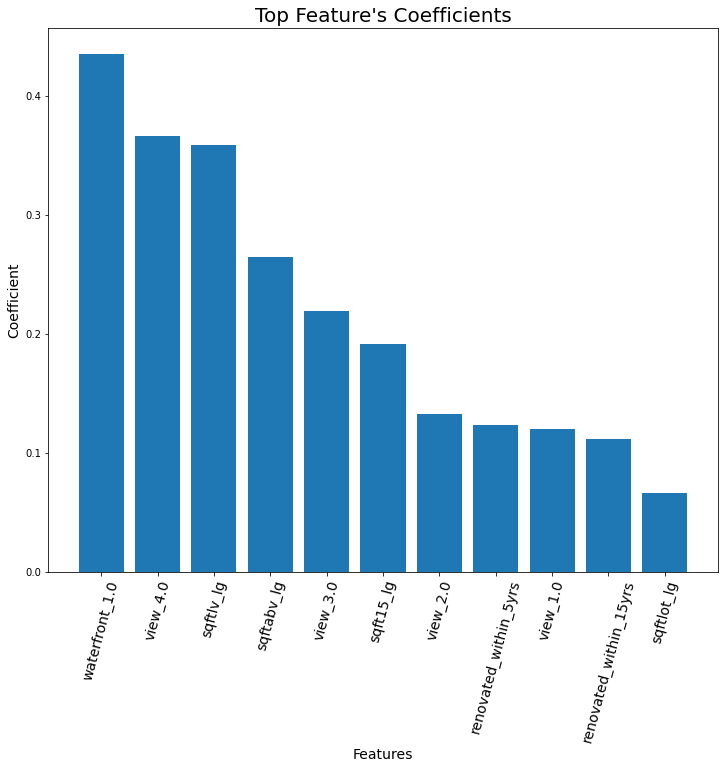

In [91]:
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(x_bar, y_bar)
ax.set_xlabel('Features', fontsize=14)
ax.set_xticklabels(x_bar, rotation=75, fontsize=14)
ax.set_ylabel('Coefficient', fontsize=14)
ax.set_title('Top Feature\'s Coefficients', fontsize=20)
plt.savefig('./images/coeff_bar_ppt',bbox_inches='tight');

<ipython-input-92-364df068de62>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_bar, rotation=75, fontsize=14, color='gray')
<ipython-input-92-364df068de62>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '0.2', '0.2', '0.3', '0.4'], fontsize=13, color='gray');


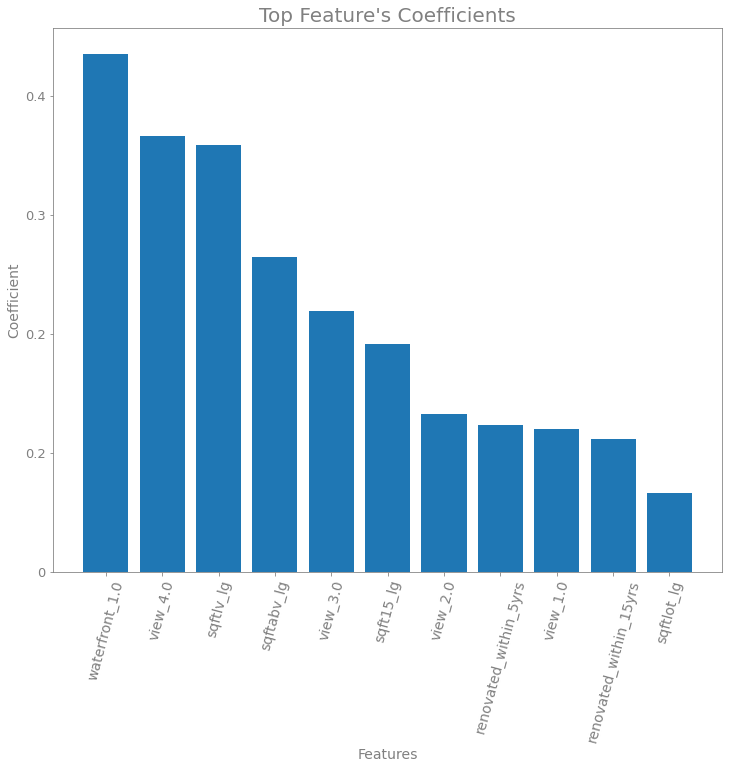

In [92]:
fig, ax = plt.subplots(figsize=(12,10))
plt.style.use=('dark_background')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.yaxis.label.set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.yaxis.label.set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.xaxis.label.set_color('gray')

ax.bar(x_bar, y_bar)
ax.set_xlabel('Features', fontsize=14)
ax.set_xticklabels(x_bar, rotation=75, fontsize=14, color='gray')
ax.set_ylabel('Coefficient', fontsize=14, color='gray')
ax.set_title('Top Feature\'s Coefficients', fontsize=20, color='gray')
ax.set_yticklabels(['0', '0.2', '0.2', '0.3', '0.4'], fontsize=13, color='gray');
plt.savefig('./images/coeff_bar_dark',bbox_inches='tight', transparent=True);

In [35]:
# Creating a list with the top five zipcodes with the highest model coefficients
sortedz = model_3.params.sort_values(ascending=False,)[:5]

In [39]:
sortedz

const            5.917957
zipcode_98039    1.411146
zipcode_98004    1.192063
zipcode_98112    1.167862
zipcode_98102    1.111898
dtype: float64

<ipython-input-36-827507f11c88>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(area_labels, rotation=18);


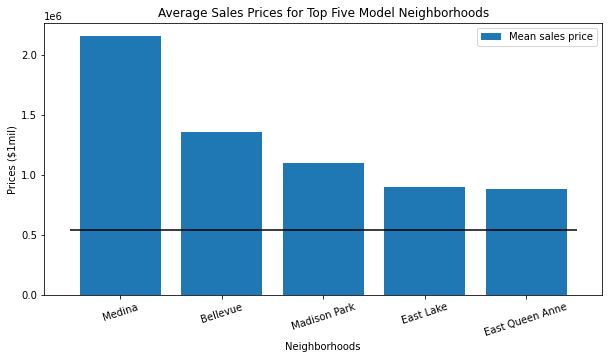

In [36]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.style.use=('use_dark_background')

#top5 model neighborhood label for plot
area_labels = ["Medina", "Bellevue", "Madison Park", 
               "East Lake", "East Queen Anne"]
#mean for the top 5 Model neighborhoods.
zip_price = [2.161300e+06,1.356524e+06,1.096239e+06, 8.996077e+05,8.800778e+05]

ax.bar(area_labels, zip_price)
ax.set_title('Average Sales Prices for Top Five Model Neighborhoods')
ax.set_xlabel('Neighborhoods')
ax.set_ylabel('Prices ($1mil)')
ax.legend(['Mean sales price', 'Average Price'])
plt.hlines(kc.price.mean(), -.5 ,4.5, colors="black", label="Average Price")
ax.set_xticklabels(area_labels, rotation=18);
#plt.savefig('./images/Mean_Sales_Zip_Price',bbox_inches='tight')

C:\Users\Erin Vu\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


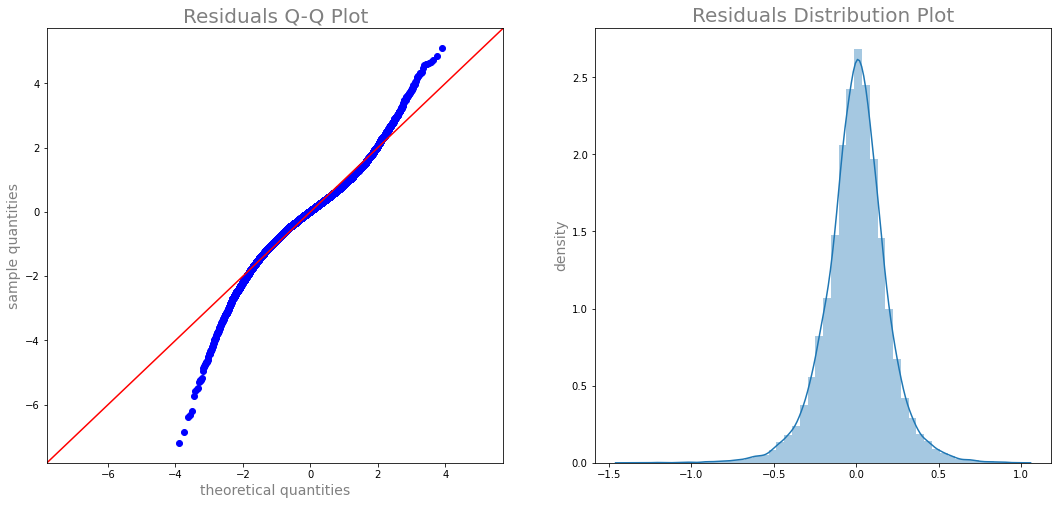

In [127]:
fig, axs, = plt.subplots(ncols=2, figsize = (18,8))
plt.style.use=('dark_background')
ax[0].spines['bottom'].set_color('gray')
ax[0].spines['top'].set_color('gray')
ax[0].spines['left'].set_color('gray')
ax[0].spines['right'].set_color('gray')
ax[0].yaxis.label.set_color('gray')
ax[0].tick_params(axis='x', colors='gray')
ax[0].yaxis.label.set_color('gray')
ax[0].tick_params(axis='y', colors='gray')
ax[0].xaxis.label.set_color('gray')
ax[1].spines['bottom'].set_color('gray')
ax[1].spines['top'].set_color('gray')
ax[1].spines['left'].set_color('gray')
ax[1].spines['right'].set_color('gray')
ax[1].yaxis.label.set_color('gray')
ax[1].tick_params(axis='x', colors='gray')
ax[1].yaxis.label.set_color('gray')
ax[1].tick_params(axis='y', colors='gray')
ax[1].xaxis.label.set_color('gray')
residuals = model_3.resid
sm.graphics.qqplot(residuals, dist = stats.norm, line='45', fit=True, ax=axs[0])
axs[0].set_title('Residuals Q-Q Plot', fontsize=20, color='gray')
sns.distplot(residuals, ax=axs[1])
axs[0].set_xlabel('theoretical quantities', color='gray', fontsize=14)
axs[0].set_ylabel('sample quantities', color='gray', fontsize=14)
axs[1].set_ylabel('density', color='gray', fontsize=14)
axs[1].set_title('Residuals Distribution Plot', fontsize=20, color='gray')
plt.savefig('./images/final_model_residuals_qq_dist_dark',bbox_inches='tight', transparent=True);

In [ ]:

ax.set_xlabel('Features', fontsize=14)
ax.set_xticklabels(x_bar, rotation=75, fontsize=14, color='gray')
ax.set_ylabel('Coefficient', fontsize=14, color='gray')
ax.set_title('Top Feature\'s Coefficients', fontsize=20, color='gray')
ax.set_yticklabels(['0', '0.2', '0.2', '0.3', '0.4'], fontsize=13, color='gray');
plt.savefig('./images/coeff_bar_dark',bbox_inches='tight', transparent=True);

C:\Users\Erin Vu\anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


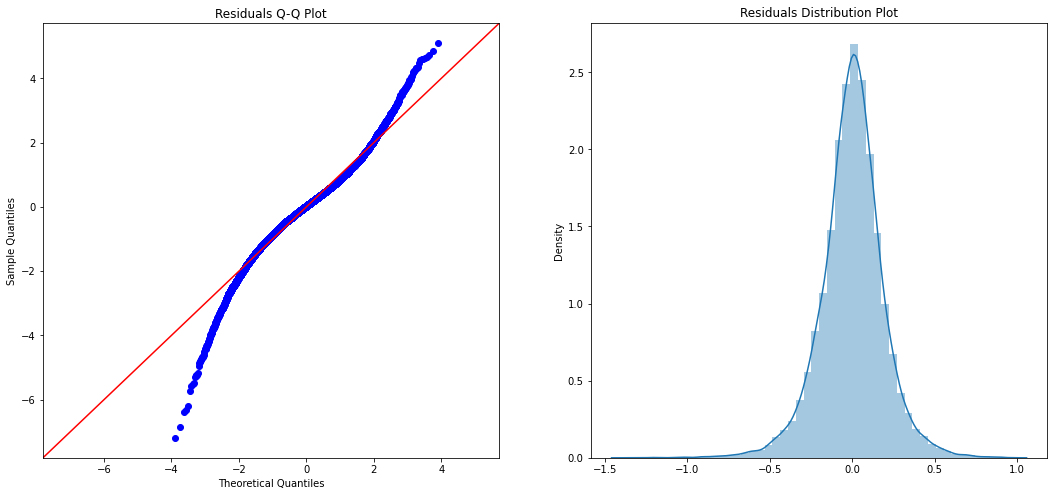

In [103]:
fig, axs = plt.subplots(ncols=2, figsize =(18,8))

residuals = model_3.resid
sm.graphics.qqplot(residuals, dist = stats.norm, line='45', fit=True, ax=axs[0])
axs[0].set_title('Residuals Q-Q Plot')
sns.distplot(residuals, ax=axs[1])
axs[1].set_title('Residuals Distribution Plot')
plt.savefig('./images/final_model_residuals_qq_dist',bbox_inches='tight');

KeyboardInterrupt: 

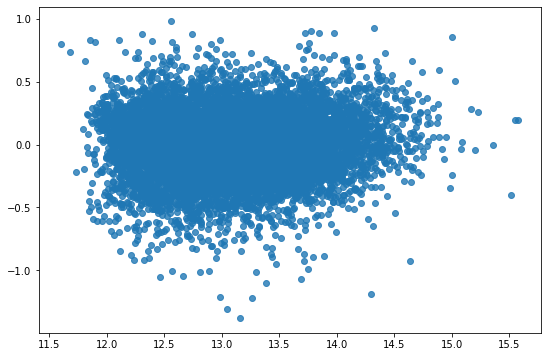

In [97]:
plt.figure(figsize=(9,6))
sns.regplot(x=model_3.predict(), y=model_3.resid, lowess=True, line_kws={'color': 'red'})
plt.title('Residuals Scatterplot')

## Statistical Analysis of the model with the number of bedrooms in property located within zipcodes that have almost the same mean sales prices

The introduction of the interaction between the property number of bedrooms and the zipcodes with almost similar property mean sales prices gives the model an r squared value of 0.82 meaning that the model has a significant potion of features to be used for sales price predictions.

The following features' impact to the property values stand as per this model:
- Properties located in zipcodes where the mean sales price are higher within Kings County are more likely to have significnatly higher propery values as their number of bedrooms increase. 
- Properties with waterfronts are more likely to have higher value than those without.
- The size of both square footage of interior housing living space for the nearest 15 neighbors and square footage of property positively affect the property value. 
- The number of times house has been viewed posivitely increases it's property value.
- Revonating properties every 5 years or 15 years almost affects the property value in the same way.

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.style.use=('use_dark_background')
#top5 model neighborhood label for plot
area_labels = ["Medina-98039", "Bellevue-98004", "Madison Park-98112",
               "East Lake-98102", "East Queen Anne-98109"]
#mean for the top 5 Model neighborhoods.
zip_price = [2.161300e+06,1.356524e+06,1.096239e+06, 8.996077e+05,8.800778e+05 ]
ax.bar(area_labels, zip_price)
ax.set_title('Average Sales Prices for Top Five Model Neighborhoods', fontsize=20)
ax.set_xlabel('Neighborhoods', fontsize=16)
ax.set_ylabel('Prices ($1mil)', fontsize=16)
ax.legend(['Mean sales price', 'Average Price'])
plt.hlines(kc.price.mean(), -.5 ,4.5, colors="black", label="Average Price")
ax.set_xticklabels(area_labels, rotation=25, fontsize=15)
ax.set_yticklabels(['0', '0.5', '1.0', '1.5', '2.0'], fontsize=13);
#plt.savefig('./images/Mean_Sales_Zip_Price',bbox_inches='tight')

In [ ]:
# Box plot comparison of house prices with no waterfront view vs house prices with waterfront view.
sns.set_style("whitegrid") 
ax = sns.catplot(x="view", y="price", kind="box", data=kc)
plt.title('Number of Views VS Housing Prices')
#plt.savefig('./images/Number_of_Views.png',dpi=300, bbox_inches = "tight")